# Select images based on network uncertainty
One way to select more data is taking images your neural network might get confused by. The idea behind this is that if it's clear to a neural network what an input is, the neural network will respond the same, even if there is a bit of noise in the input image. However, if an input is on a 'decision boundary', adding a little bit of noise might flip the decision of the network. 

If you annotate the images which are close on the decision boundary you hope to make this bounday clearer to the neural network. In this notebook I will show a simple way of doing this with a VGG16 neural network. 

In this notebook I will demonstrate what happens if you add noise to the input image, and select images based on the standard deviation in the latent features of a neural network. 

At the end of this notebook I will have a small discussion around different ways you can select based on uncertainty. 

In [1]:
# Get the imports needed for this project. 
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

## Create a neural network with pre-trained weights
As a neural network I will take a VGG16 neural network with a global maxpooling operator on top. The global max pooling ensures we have a feature vector of 512 features as output of the neural network. 

The one big difference here though is that I add gaussian noise just before feeding images to the neural network. 

The neural network is trained on imagenet. This is not ideal, as we mostly want to get images which are causing uncertainty for a neural network that goes into a self-driving car. However, it's easy to read this tutorial this way, and it's easy to plug in your own network if you want!

In [3]:
vgg16 = VGG16(weights='imagenet', include_top=False)
model = tf.keras.Sequential(layers=[tf.keras.layers.GaussianNoise(0.2), 
                                    vgg16, 
                                    tf.keras.layers.GlobalMaxPool2D() ])

## Analyse your unannotated data
To select from your annotated data it's important to get inference results from the neural network we built, and store those in a list which links the filenames to the features. 

In [4]:
# Build a database with all imags, except for the last 1000 
folder = '/datasets/mappilary_scrape/images'
stdev_filename = list()

In [20]:
images_to_select = os.listdir(folder)[:len(os.listdir(folder)) - 1000]
already_existing = set([x[1] for x in stdev_filename])
images_to_select = [x for x in images_to_select if not x in already_existing]
print("To go: ", len(images_to_select))

def get_features_from_image(filename):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)    
    return features, img


# Get the features for the images and store the standard deviation in a list. 
for image_filename in images_to_select:
    img_path = os.path.join(folder , image_filename)

    all_features = list()
    for i in range(10):
        features, img = get_features_from_image(img_path)
        all_features.append(features)
    
    combined_features = np.array(all_features).reshape(-1,512)        

   # print(sum(combined_features.std(axis=0)))
    stdev_filename.append((sum(combined_features.std(axis=0)), image_filename))

To go:  296432


KeyboardInterrupt: 

## Visualising the most uncertain images
Now that we have a list with uncertainty and filenames, let's sort the list and look at the images with the highest standard deviation values. Hopefully they are worth annotating and a worthy addition to our self-driving dataset. 

0.0014588087797164917


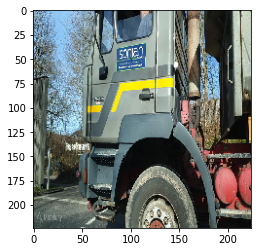

0.0012285113334655762


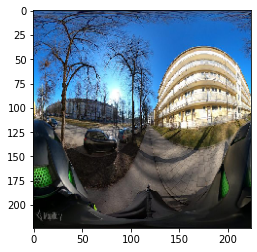

0.0012096166610717773


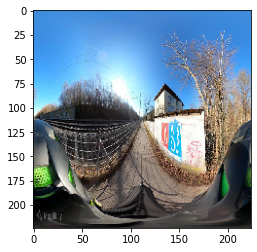

0.001179426908493042


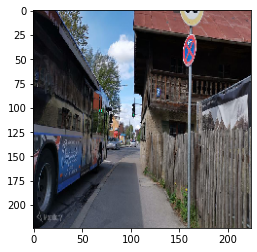

0.0011747777462005615


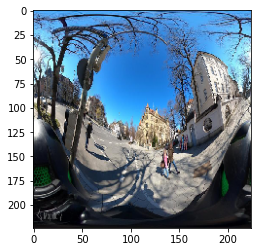

In [18]:
for uncertainty, filename in sorted(stdev_filename, reverse=True)[:5]:
    img_path = os.path.join(folder , filename)
    img = image.load_img(img_path, target_size=(224, 224))
    print(uncertainty)
    plt.imshow(img)
    plt.show()

## Visualising the least uncertain images
Let's also reverse-sort the list and look at the images we would have never annotated... Hopefully our self-driving dataset is not missing our on any really interesting images!

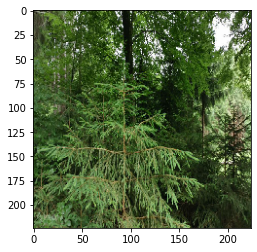

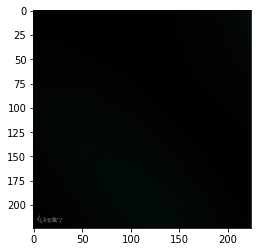

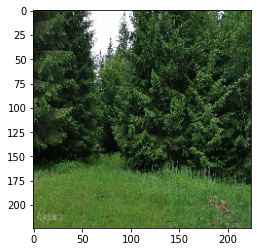

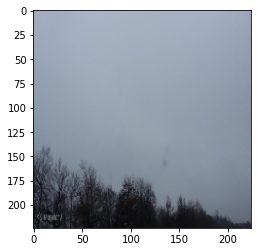

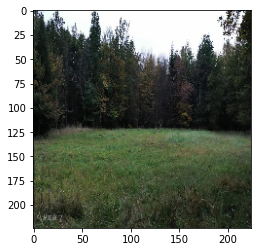

In [19]:
for uncertainty, filename in sorted(stdev_filename, reverse=False)[:5]:
    img_path = os.path.join(folder , filename)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

## Conclusion and discussion
Looking at the output results we see that the selected data is actually pretty interesting. There are weird trucks, weird cameras, roadworks, and other situations which are not very normal for a car to be in. The not-selected data seems to be mostly trees and nature, where adding noise does not cause big differences in interpretation (trees are really noisy by nature). 

There are actually multiple ways we could select data. I can recommend trying to following things for yourself:
- Add noise to the input image and see if the latent representation switches a lot (done in this notebook)
- Add noise to the input image and see if the final predictions change
- Add noise to the latent features see if the final predictions change. 
